# NGC2264 local

In [1]:
import aplpy
from astropy.io import fits
%matplotlib widget
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pywavan import powspec, fan_trans, fbm2d, apodize, padding, locspec

In [3]:
import pandas as pd

In [41]:
cores = pd.read_excel("/user/workdir/albouyg/HOBYS/NGC2264_loc/NGC2264_cores.xlsx")
nb = cores['Nb'].to_numpy()
ac = cores[' RA'].to_numpy()
dec = cores['DEC'].to_numpy()
width = cores[' A_FWHM'].to_numpy()
height = cores[' B_FWHM'].to_numpy()
angle = cores[' Theta'].to_numpy()
mass = cores[' Mass'].to_numpy()

In [42]:
nb= nb[~np.isnan(nb)]
ac= ac[~np.isnan(ac)]
dec= dec[~np.isnan(dec)]
width= width[~np.isnan(width)]
height= height[~np.isnan(height)]
angle= angle[~np.isnan(angle)]
mass= mass[~np.isnan(mass)]

In [50]:
ac.size

256

In [44]:
figfile = '/user/workdir/albouyg/HOBYS/ngc2264/ngc2264_coldens_cf_r500_medsmo3_rebin_rot_cut.fits'

INFO: Auto-setting vmin to  1.572e+21 [aplpy.core]
INFO: Auto-setting vmax to  5.108e+22 [aplpy.core]


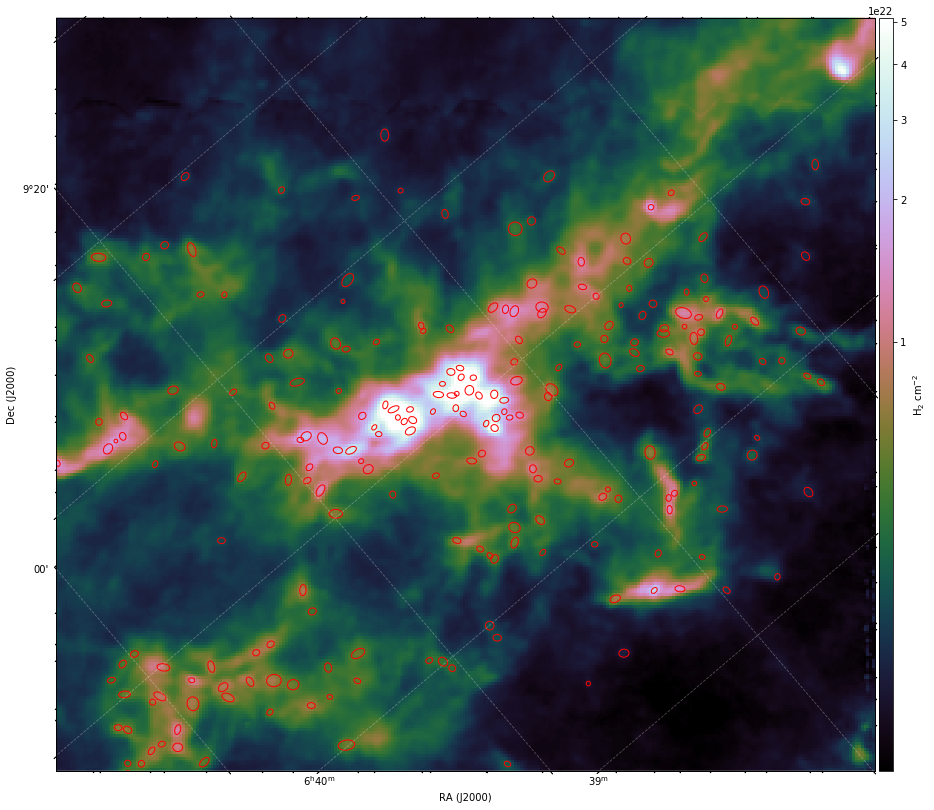

In [45]:
fig_all = plt.figure(1, figsize=(15,15))

fig = aplpy.FITSFigure(figfile,figure=fig_all)
fig.show_colorscale(cmap='cubehelix',stretch='arcsinh')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
#fig.set_title("NGC2264")
fig.add_grid()
fig.grid.set_color('white')
fig.grid.set_alpha(0.3)
fig.grid.set_linestyle('--')
fig.show_ellipses(ac, dec, width/3600, height/3600, angle=angle, edgecolor='red', facecolor='none')
#for ii in range(256):
#    fig.add_label(ac[ii], dec[ii], ii, color='black',fontsize=18)
#ii = 32
#fig.add_label(ac[ii], dec[ii], ii, color='yellow',fontsize=18)
(xp, yp) = fig.world2pixel(ac, dec)

#plt.tight_layout()
#figpath = '/Users/robitaij/postdoc/NGC2264_letter/paper/figures/'
#plt.savefig(figpath+'NGC2264.pdf',dpi=150,bbox_inches='tight')

In [15]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data

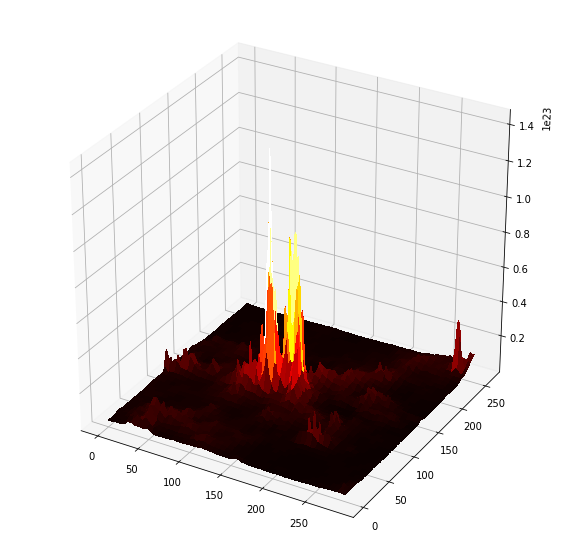

In [16]:
from mpl_toolkits.mplot3d import Axes3D
dim2=im.shape[0]
dim1=im.shape[1]
X=np.linspace(0,dim1-1,dim1)
Y=np.linspace(0,dim2-1,dim2)
X,Y=np.meshgrid(X,Y)
fig=plt.figure(figsize=(10,10))
ax=plt.axes(projection='3d')
#ax.set_zlim([-0.3,0.3])
ax.plot_surface(X,Y,im,cmap='hot',antialiased=False)
#ax.view_init(45,45)

In [17]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

In [18]:
#Set a list of q
q=[]
q=[2.5]*26
newdim = np.array((400,400))

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(im, reso=reso, q=q, qdyn=True, skewl=0.4, arrdim = newdim, smooth=False, angular=True)

400 400


In [23]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

meanim = np.mean(im)
na = im.shape[1]
nb = im.shape[0]
imzm = im - meanim

#Apodization
tapper = apodize(nb,na,0.98)
imt = imzm *tapper
newdim = np.array((400,400))
imr = padding(imt,newdim[0],newdim[1])

#Fourier power spectrum
tab_k, spec_k = powspec(imr, reso=reso)

noise = np.mean(spec_k[(tab_k > 1.65) & (tab_k < 2.0)])

In [24]:
beam500 = fits.open('/user/workdir/albouyg/Gouldbelt/empiral_spire_beam_500.fits')[0].data

beam500r = padding(beam500,newdim[0],newdim[1])
Bwt, BS11a, wav_k, BS1a, Bq = fan_trans(beam500r, reso=reso, q=0, smooth=False, angular=False)
del Bwt, BS11a, Bq

BS1an = BS1a / BS1a[3]
BS1an[:3] = 1.0  #Spectrum normalisation

tab_k, spec_kbeam = powspec(beam500r, reso=reso)
spec_kbeamn = spec_kbeam/spec_kbeam[0]

Power law fit
Coherent wavelet
A, Gamma, P0 =  5.80424e+42 -2.29398 2.80591e+42
Gaussian wavelet
A, Gamma, P0 =  2.07945e+39 -4.55521 5.26325e+39


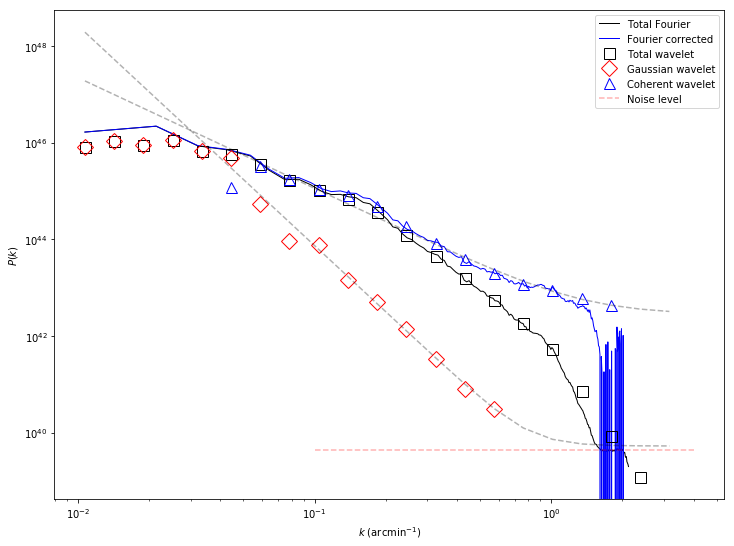

In [25]:
#Power spectra fits
A_gauss, gamma_gauss, P0_gauss = 0.0207945e+41, -4.55521, 0.0526325e+41
fit_gauss=A_gauss*wav_k**gamma_gauss+P0_gauss
A_cohe, gamma_cohe, P0_cohe = 58.0424e+41, -2.29398, 28.0591e+41
fit_cohe=A_cohe*wav_k**gamma_cohe+P0_cohe

print('Power law fit')
print('Coherent wavelet')
print('A, Gamma, P0 = ', A_cohe, gamma_cohe, P0_cohe)
print('Gaussian wavelet')
print('A, Gamma, P0 = ', A_gauss, gamma_gauss, P0_gauss)

plt.figure(figsize(12,9))
plt.plot(tab_k, spec_k, color='black',label=r'Total Fourier', lw=1.0)
plt.plot(tab_k, (spec_k-noise)/spec_kbeamn, color='blue',label=r'Fourier corrected', lw=1.0)
plt.plot(wav_k[:-1], S1a[0,:-1],'s', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Total wavelet')
plt.plot(wav_k[:-1], (S1a[2,:-1]-noise)/BS1an[:-1],'D', markersize = 11, markerfacecolor='none', markeredgecolor='red', label='Gaussian wavelet')
plt.plot(wav_k[:-1], (S1a[1,:-1]-noise)/BS1an[:-1],'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')
plt.plot([1e-1,4],[noise,noise],'--',color='red',linewidth=1.5,alpha=0.3,label='Noise level')
plt.plot(wav_k, fit_gauss,'--',color='black', linewidth=1.5, alpha=0.3)
plt.plot(wav_k, fit_cohe,'--',color='black', linewidth=1.5, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

## Image Reconstruction

In [26]:
M = wav_k.shape[0]

coherent = np.sum(wt[M:2*M,:,:,:],axis=(0,1)) + np.sum(wt[2*M:2*M+8,:,:,:],axis=(0,1)) + meanim
Gaussian = np.sum(wt[2*M+7:3*M,:,:,:],axis=(0,1)) + meanim

fits.writeto('/user/workdir/albouyg/HOBYS/NGC2264_loc/NGC2264_coherent.fits',\
            coherent.real,header,overwrite=True)
fits.writeto('/user/workdir/albouyg/HOBYS/NGC2264_loc/NGC2264_gauss.fits',\
            Gaussian.real,header,overwrite=True)

INFO: Auto-setting vmin to -1.399e+21 [aplpy.core]
INFO: Auto-setting vmax to  1.740e+21 [aplpy.core]
INFO: Auto-setting vmin to -2.962e+21 [aplpy.core]
INFO: Auto-setting vmax to  5.204e+22 [aplpy.core]


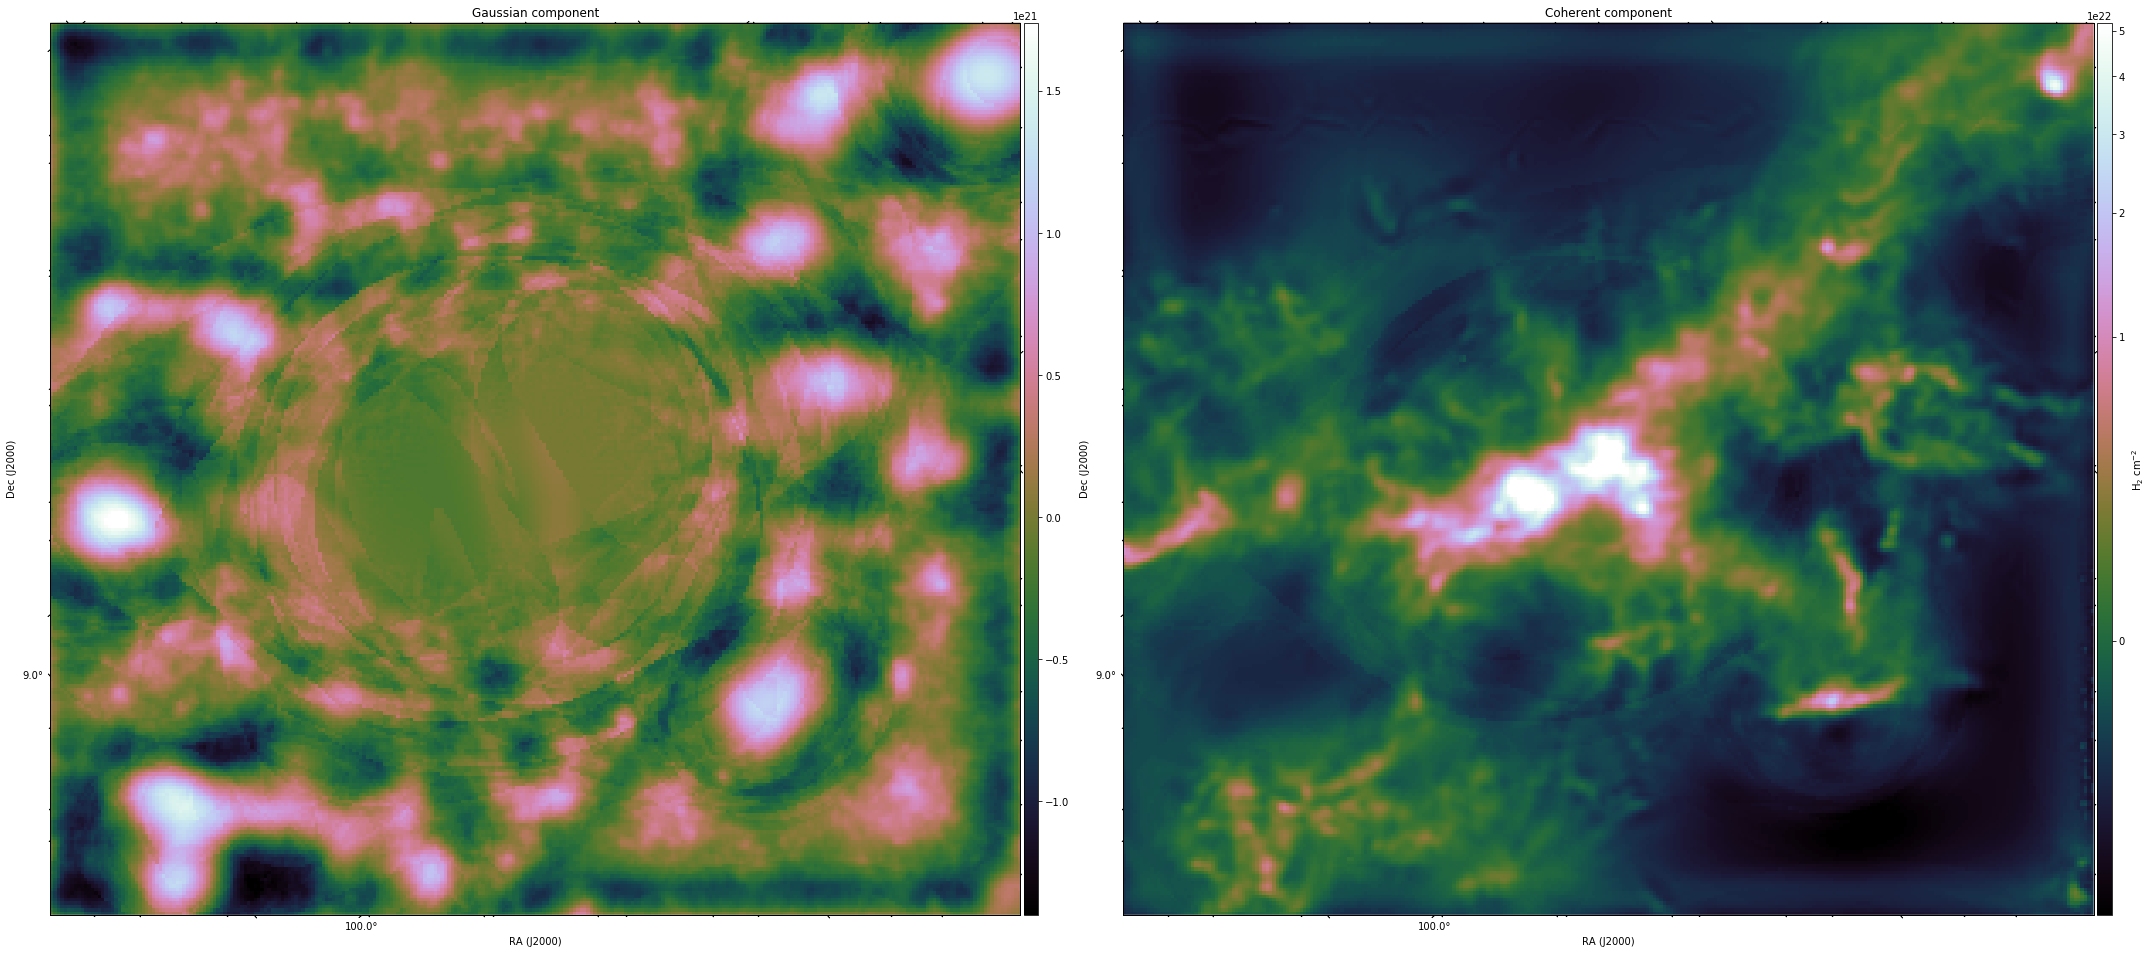

In [27]:
fig_all = plt.figure(1, figsize=(30,30))

figfile = '/user/workdir/albouyg/HOBYS/NGC2264_loc/NGC2264_gauss.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 1))
fig.show_colorscale(cmap='cubehelix')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.set_title('Gaussian component')

figfile = '/user/workdir/albouyg/HOBYS/NGC2264_loc/NGC2264_coherent.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 2))
fig.show_colorscale(cmap='cubehelix',stretch='arcsinh')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
fig.set_title('Coherent component')

plt.tight_layout()

Mass =  1.2
Power fit
A, Gamma =  2.21252741768417e+42 -1.9888038881173973
Uncertainties =  1.8567994660445901 0.5182045065149874


/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: Mean of empty slice
  if __name__ == '__main__':


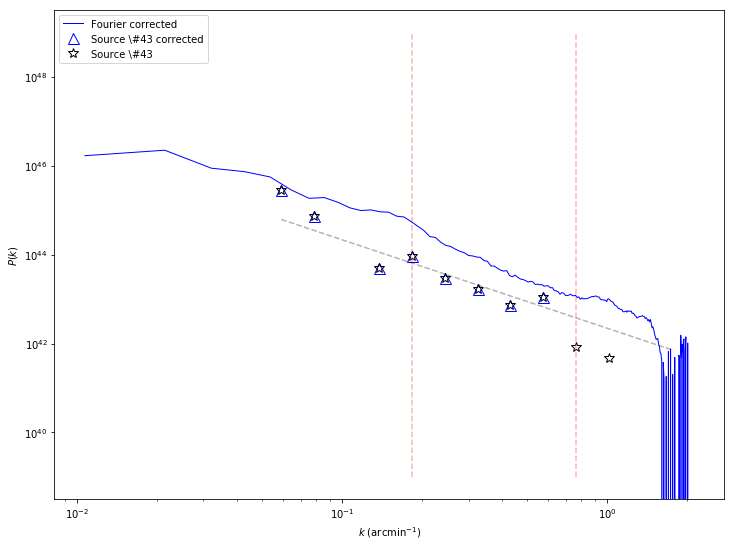

In [51]:
src = 43
xpr, ypr = np.int(xp[src]),np.int(yp[src])
coords = np.array((xpr, ypr))
smin, smax = (6,18)

locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt[M:2*M,:,:], reso, smin, smax, radlim=0.5, phaslim=0.25)

#Clean NaN for fit
Mlocpow = np.nanmean(locpow, axis=0)
wav_nonan = wav_k[smin:smax+1]
wav_nonan = wav_nonan[~np.isnan(Mlocpow)]
Mlocpow_nonan = Mlocpow[~np.isnan(Mlocpow)]
BS1a_nonan = BS1an[smin:smax+1]
BS1a_nonan = BS1a_nonan[~np.isnan(Mlocpow)]

#Fit limits
flim = np.where((wav_nonan >= wav_k[smin+4]) & (wav_nonan < wav_k[smax-3]))

#Power spectra fits
A, cov = np.polyfit(np.log(wav_nonan[flim]), np.log((Mlocpow_nonan[flim]-noise)/(BS1a_nonan[flim])),deg=1,cov=True)
fit = np.exp(A[1])*wav_k[smin:smax+1]**A[0]
print('Mass = ', mass[src])
print('Power fit')
print('A, Gamma = ', np.exp(A[1]), A[0])
print('Uncertainties = ', np.exp(np.sqrt(np.diag(cov)[1])), np.sqrt(np.diag(cov)[0]))

plt.figure(figsize(12,9))
plt.plot(tab_k, (spec_k-noise)/spec_kbeamn, color='blue',label=r'Fourier corrected', lw=1.0)
plt.plot(wav_k[smin:smax-3], (Mlocpow[:-4]-noise)/(BS1an[smin:smax-3]),'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Source \#'+np.str(src)+' corrected')
plt.plot(wav_nonan, (Mlocpow_nonan-noise)/BS1a_nonan,'*', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Source \#'+np.str(src))
plt.plot(wav_k[smin:smax+1], fit,'--',color='black', linewidth=1.5, alpha=0.3)
plt.plot([wav_k[smin+4],wav_k[smin+4]], [1e39,1e49],'--',color='red', linewidth=1.5, alpha=0.3)
plt.plot([wav_k[smax-3],wav_k[smax-3]], [1e39,1e49],'--',color='red', linewidth=1.5, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

### Loop over all sources

In [53]:
smin, smax = (6,18)
powlaw = np.zeros(256)
plevel = np.zeros(256)
powlaw_sig=np.zeros(256)
plevel_sig=np.zeros(256)
allxlcoords = np.zeros((256,11,smax - smin + 1))
allylcoords = np.zeros((256,11,smax - smin + 1))

for src in range(256):
    xpr, ypr = np.int(xp[src]),np.int(yp[src])
    coords = np.array((xpr, ypr))
    if (coords[0] > 0) & (coords[1] > 0) & (coords[1] < wt.shape[2]) & (coords[0] < wt.shape[3]):# & (src != 74) :
        locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt[M:2*M,:,], reso, smin, smax, radlim=0.5, phaslim=0.25)
        allxlcoords[src,:,:] = xlcoords
        allylcoords[src,:,:] = ylcoords
    Mlocpow = np.nanmean(locpow, axis=0)
    #Clean NaN for fit
    Mlocpow = np.nanmean(locpow, axis=0)
    wav_nonan = wav_k[smin:smax+1]
    wav_nonan = wav_nonan[~np.isnan(Mlocpow)]
    Mlocpow_nonan = Mlocpow[~np.isnan(Mlocpow)]
    BS1a_nonan = BS1an[smin:smax+1]
    BS1a_nonan = BS1a_nonan[~np.isnan(Mlocpow)]
    #Fit limits
    flim = np.where((wav_nonan >= wav_k[smin+3]) & (wav_nonan < wav_k[smax-3]))
    #Power spectra fits
    if flim[0].size > 2:
        A, cov = np.polyfit(np.log(wav_nonan[flim]), np.log((Mlocpow_nonan[flim]-noise)/(BS1a_nonan[flim])),deg=1,cov=True)
        powlaw[src]= A[0]
        plevel[src]= np.exp(A[1])
        powlaw_sig[src]=np.sqrt(np.diag(cov)[0])
        plevel_sig[src]=np.exp(np.sqrt(np.diag(cov)[1]))
    else:
        powlaw[src]= 'nan'
        plevel[src]= 'nan'
        powlaw_sig[src]='nan'
        plevel_sig[src]='nan'

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: Mean of empty slice
  app.launch_new_instance()
/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


Text(0, 0.5, 'Counts')

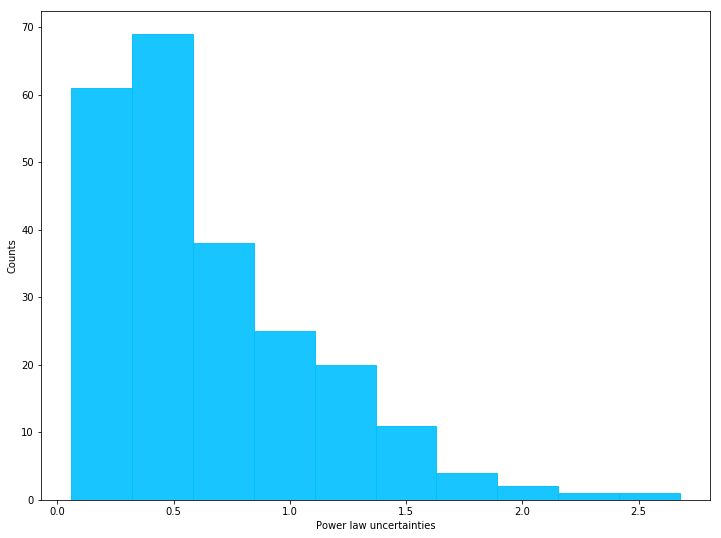

In [54]:
sighist, sigedges = np.histogram(powlaw_sig[~np.isnan(powlaw_sig)] , bins=10)

figure(figsize = (12,9))
plt.bar(sigedges[:-1], sighist, width=np.diff(sigedges), align="edge",\
        edgecolor='#00BFFF',facecolor='#00BFFF',alpha=0.9,\
        label= r'Power laws')
#plt.plot([-4.0,-4.0], [0,38],'--',color='red', linewidth=1.5, alpha=1.0)
#plt.plot([-2.5,-2.5], [0,38],'--',color='red', linewidth=1.5, alpha=1.0)
#plt.xlim([-4.0,-0.5])
plt.xlabel(r'Power law uncertainties')
plt.ylabel(r'Counts')

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


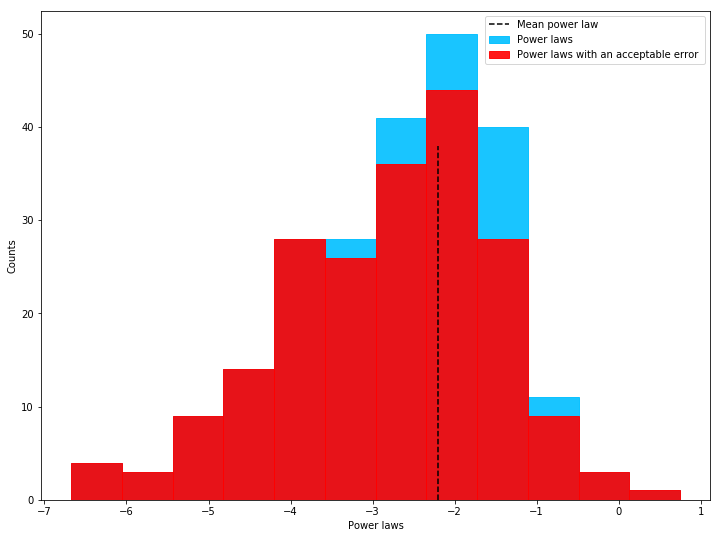

In [122]:
histo, edges = np.histogram(powlaw[~np.isnan(powlaw)],bins=12)
histo1, edges1 = np.histogram(powlaw[(~np.isnan(powlaw)) & (powlaw_sig < .5)],bins=edges)
histo1, edges1 = np.histogram(powlaw[(~np.isnan(powlaw)) & (mass < 5)],bins=edges)

figure(figsize = (12,9))
plt.bar(edges[:-1], histo, width=np.diff(edges), align="edge",\
        edgecolor='#00BFFF',facecolor='#00BFFF',alpha=0.9,\
        label= r'Power laws')
plt.bar(edges1[:-1], histo1, width=np.diff(edges1), align="edge",\
        edgecolor='red',facecolor='red',alpha=0.9,\
        label= r'Power laws with an acceptable error ')
#plt.plot([-4.0,-4.0], [0,38],'--',color='red', linewidth=1.5, alpha=1.0)
plt.plot([-2.2,-2.2], [0,38],'--',color='black', linewidth=1.5, alpha=1.0, label='Mean power law')
#plt.xlim([-4.0,-0.5])
plt.xlabel(r'Power laws')
plt.ylabel(r'Counts')
plt.legend()
#figpath = '/Users/robitaij/postdoc/NGC2264_letter/paper/figures/'
#plt.savefig(figpath+'NGC2264_locpow_dist.pdf',dpi=150,bbox_inches='tight')

In [101]:
np.mean(powlaw[(~np.isnan(powlaw)) & (powlaw_sig < .5)])

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


-2.2858510188028234

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Mean of empty slice
  if sys.path[0] == '':


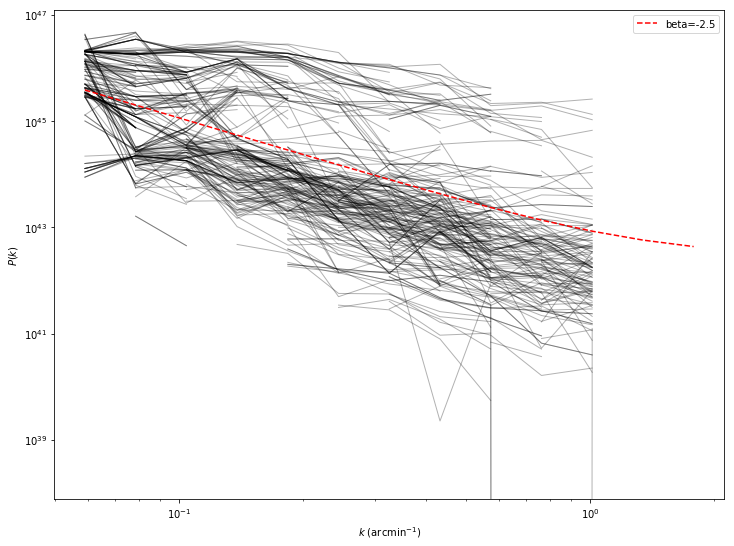

In [58]:
#mod1 = 6.51416e+39*wav_k**-3.3
#mod2 = 4.02638e+42*wav_k**-2.04

condition=np.where(powlaw_sig < .75)
plt.figure(figsize(12,9))
#for src in condition[0]:
for src in range(256):
    xpr, ypr = np.int(xp[src]),np.int(yp[src])
    coords = np.array((xpr, ypr))
    if (coords[0] > 0) & (coords[1] > 0) & (coords[1] < wt.shape[2]) & (coords[0] < wt.shape[3]):
        locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt, reso, smin, smax, radlim=0.5, phaslim=0.25)
    Mlocpow = np.nanmean(locpow, axis=0)
    plt.plot(wav_k[smin:smax+1], (Mlocpow-noise)/BS1an[smin:smax+1],lw=1.0, alpha=0.3, color='black')

plt.plot(wav_k[smin:smax+1], fit_cohe[smin:smax+1],'--',color='red',lw=1.5, ls='--', label='beta=-2.5')
#plt.plot(wav_k[smin:smax+1], mod1[smin:smax+1],lw=1.5, ls='-.', color='black', label='beta=-4.0')
#plt.plot(wav_k[smin:smax+1], mod2[smin:smax+1],lw=1.5, ls='--', color='black', label='beta=-2.5')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

#plt.savefig(figpath+'NGC2264_locpow_all.pdf',dpi=150,bbox_inches='tight')

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


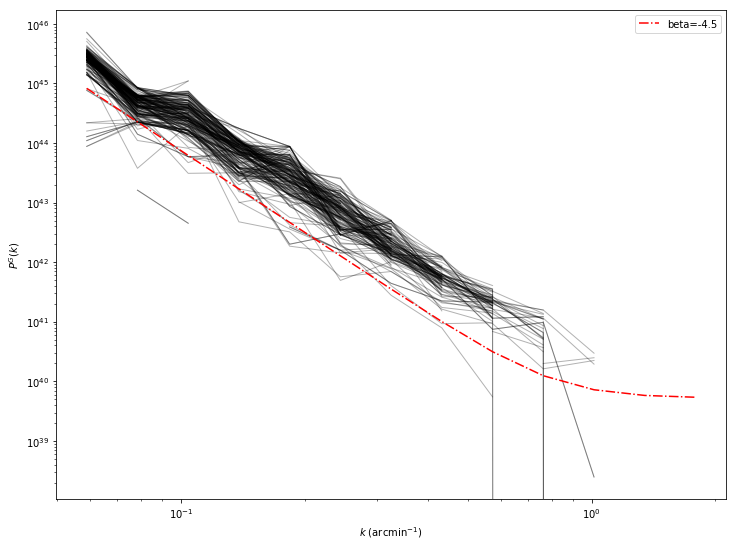

In [59]:
mod1 = 6.51416e+39*wav_k**-3.3
mod2 = 4.02638e+42*wav_k**-2.04

plt.figure(figsize(12,9))
for src in range(256):
    xpr, ypr = np.int(xp[src]),np.int(yp[src])
    coords = np.array((xpr, ypr))
    if (coords[0] > 0) & (coords[1] > 0) & (coords[1] < wt.shape[2]) & (coords[0] < wt.shape[3]):
        locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt[2*M:3*M,:,:], reso, smin, smax, radlim=0.5, phaslim=0.25)
    Mlocpow = np.nanmean(locpow, axis=0)
    plt.plot(wav_k[smin:smax+1], (Mlocpow-noise)/BS1an[smin:smax+1],lw=1.0, alpha=0.3, color='black')

plt.plot(wav_k[smin:smax+1], fit_gauss[smin:smax+1],lw=1.5, ls='-.', color='red', label='beta=-4.5')
#plt.plot(wav_k[smin:smax+1], mod2[smin:smax+1],lw=1.5, ls='--', color='black', label='beta=-2.5')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P^{G}(k)$')
plt.legend()

#plt.savefig(figpath+'NGC2264_locpow_Gaussian_all.pdf',dpi=150,bbox_inches='tight')

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.


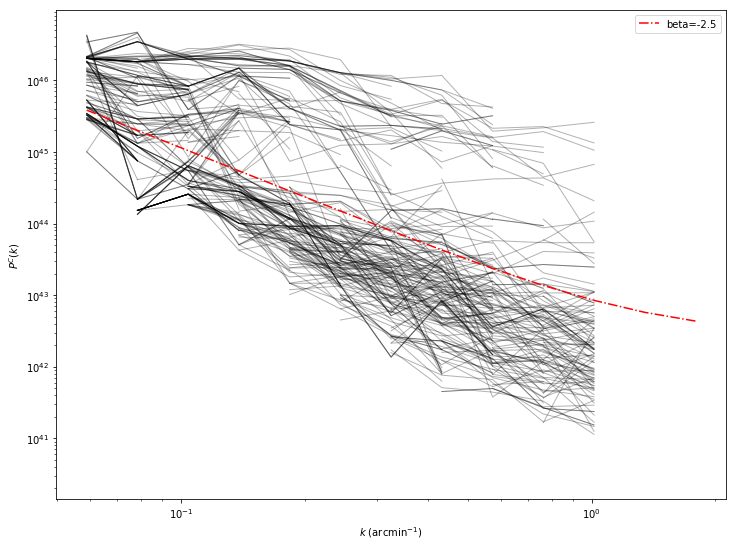

In [60]:
mod1 = 6.51416e+39*wav_k**-3.3
mod2 = 4.02638e+42*wav_k**-2.04

plt.figure(figsize(12,9))
for src in range(256):
    xpr, ypr = np.int(xp[src]),np.int(yp[src])
    coords = np.array((xpr, ypr))
    if (coords[0] > 0) & (coords[1] > 0) & (coords[1] < wt.shape[2]) & (coords[0] < wt.shape[3]):
        locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt[M:2*M,:,:], reso, smin, smax, radlim=0.5, phaslim=0.25)
    Mlocpow = np.nanmean(locpow, axis=0)
    plt.plot(wav_k[smin:smax+1], (Mlocpow-noise)/BS1an[smin:smax+1],lw=1.0, alpha=0.3, color='black')

plt.plot(wav_k[smin:smax+1], fit_cohe[smin:smax+1],lw=1.5, ls='-.', color='red', label='beta=-2.5')
#plt.plot(wav_k[smin:smax+1], mod2[smin:smax+1],lw=1.5, ls='--', color='black', label='beta=-2.5')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P^{C}(k)$')
plt.legend()

#plt.savefig(figpath+'NGC2264_locpow_Gaussian_all.pdf',dpi=150,bbox_inches='tight')

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


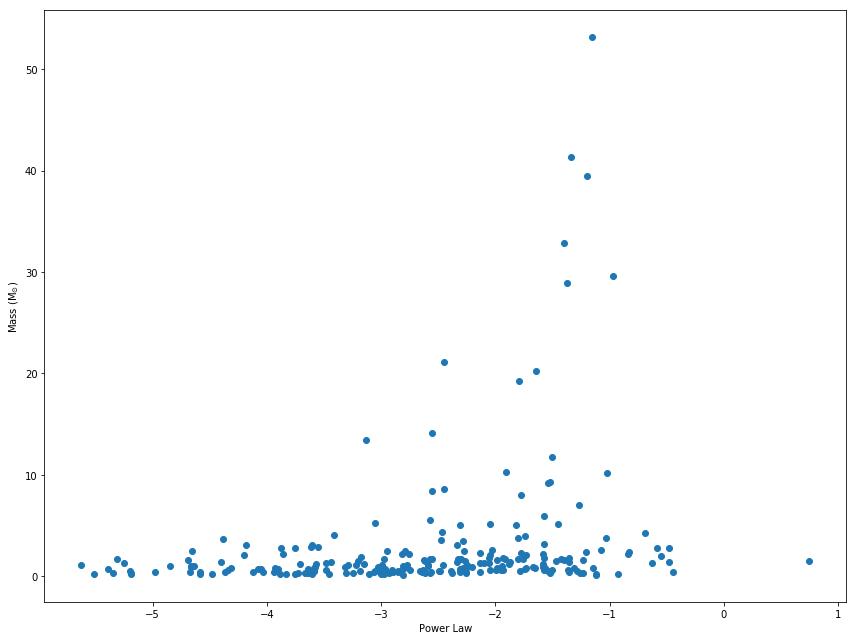

In [61]:
figure(figsize=(12,9))
scatter(powlaw[powlaw > -6.0],mass[powlaw > -6.0])
#scatter(powlaw[plevel > np.exp(1.84*powlaw + 106.15)],mass[plevel > np.exp(1.84*powlaw + 106.15)])
#scatter(powlaw,mass)
#xscale('log')
#yscale('log')
ylabel(r'Mass (M$_{\odot}$)')
xlabel(r'Power Law')

plt.tight_layout()
figpath = '/Users/robitaij/postdoc/NGC2264_letter/paper/figures/'
#plt.savefig(figpath+'NGC2264_powlaw_mass.pdf',dpi=150,bbox_inches='tight')

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


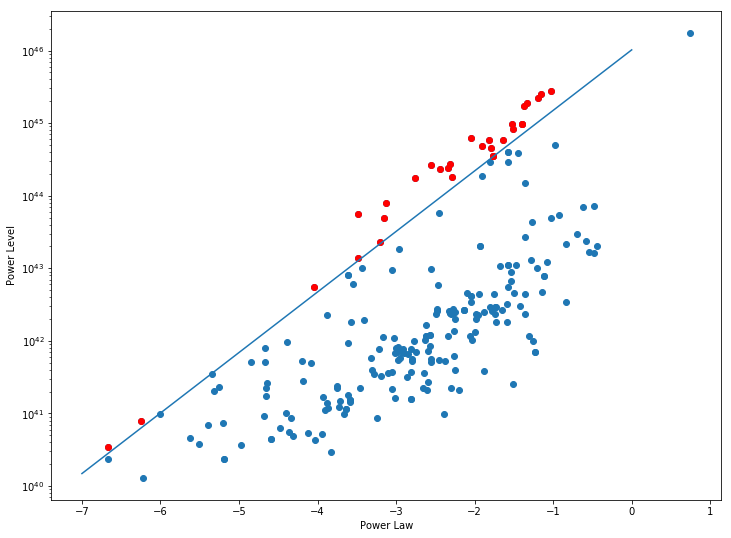

In [75]:
mlim = 5.

figure(figsize=(12,9))
scatter(powlaw, plevel)
#scatter(powlaw[mass > 1.],plevel[mass > 1.],color='red')
yscale('log')
xlabel(r'Power Law')
ylabel(r'Power Level')

xx = arange(-7.,1.)
yy = np.exp(1.92*xx + 105.94)
plot(xx,yy)
scatter(powlaw[plevel > np.exp(1.92*powlaw + 105.94)], plevel[plevel > np.exp((1.92*powlaw + 105.94))], color='red')

#plt.tight_layout()
#figpath = '/Users/robitaij/postdoc/NGC2264_letter/paper/figures/'
#plt.savefig(figpath+'NGC2264_powlaw_plevel.pdf',dpi=150,bbox_inches='tight')

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in greater
  after removing the cwd from sys.path.


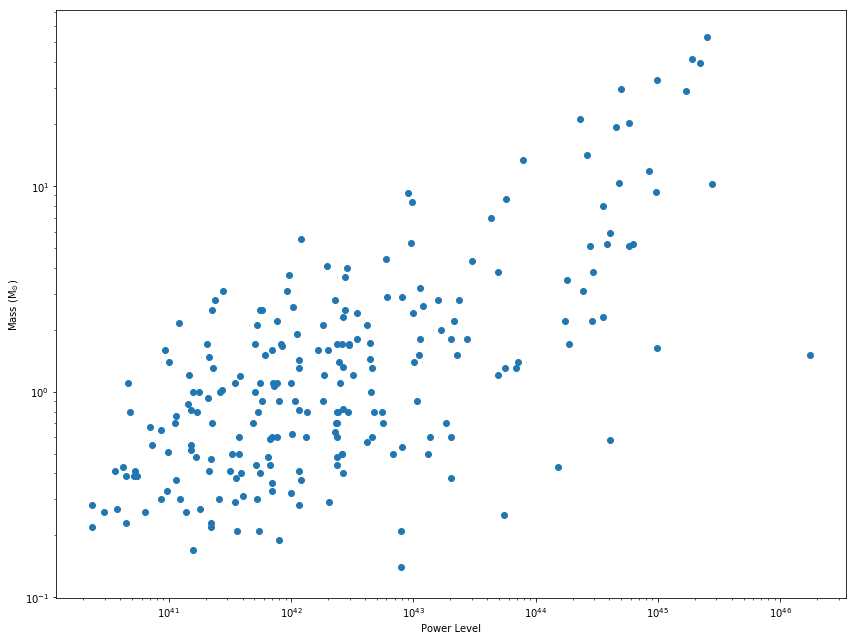

In [64]:
mlim = 5.

figure(figsize=(12,9))
scatter(plevel[powlaw > -6.0],mass[powlaw > -6.0])
ylabel(r'Mass (M$_{\odot}$)')
xlabel(r'Power Level')
xscale('log')
yscale('log')

plt.tight_layout()
figpath = '/Users/robitaij/postdoc/NGC2264_letter/paper/figures/'
#plt.savefig(figpath+'NGC2264_plevel_mass.pdf',dpi=150,bbox_inches='tight')

In [65]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib._png import read_png

In [66]:
allxlcoords[allxlcoords == 0.] = 'nan'
allylcoords[allylcoords == 0.] = 'nan'

allxlcoordsM = np.nanmean(allxlcoords, axis=1)
allylcoordsM = np.nanmean(allylcoords, axis=1)

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: Mean of empty slice
  """


/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


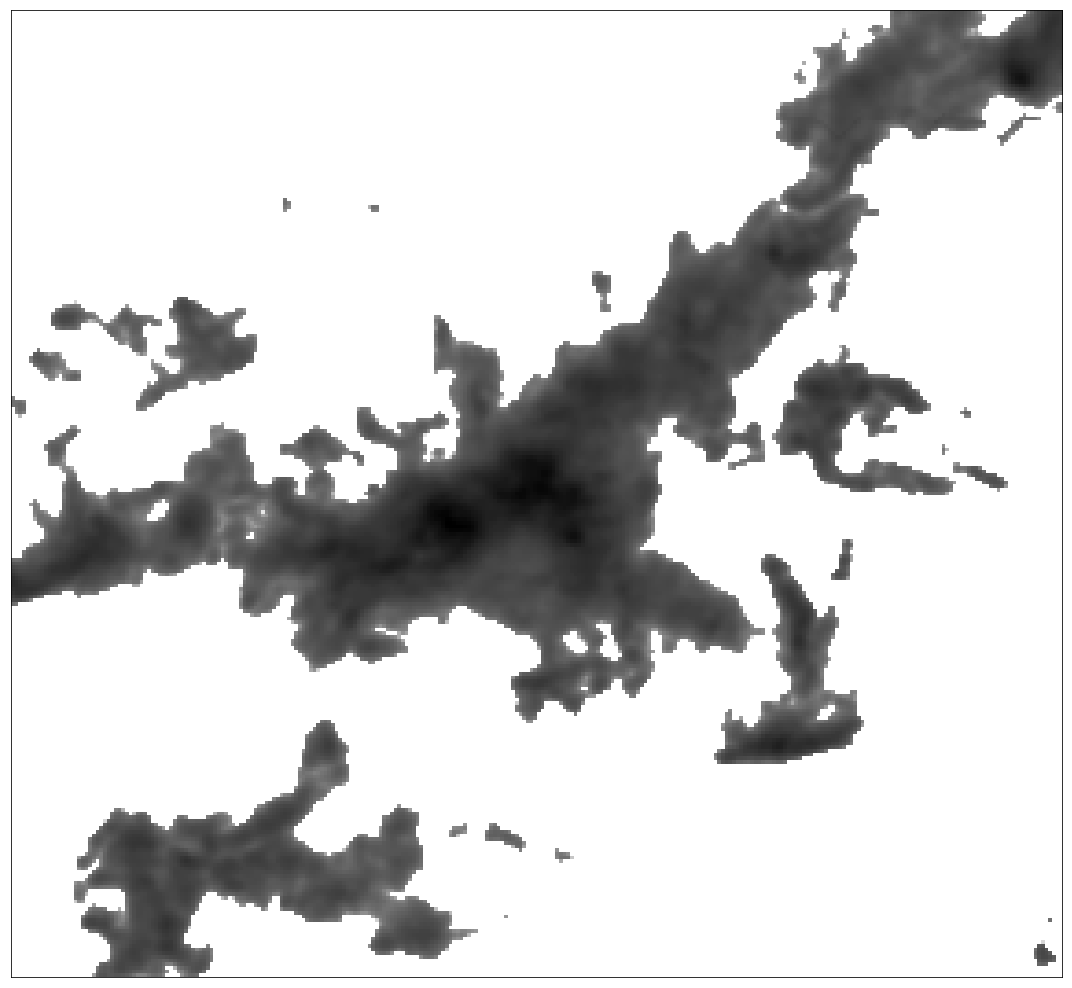

In [69]:
figure(figsize=(15,15))
imshow(np.log(im),origin='bottom',cmap='gray_r')
#plot(allxlcoordsM[193,6],allylcoordsM[193,6],'*',color='white')
#plot(103,263,'*',color='red')
xticks([])
yticks([])

plt.tight_layout()
figpath = '/user/workdir/albouyg/HOBYS/NGC2264_loc/'
plt.savefig(figpath+'NGC2264.png',dpi=50,bbox_inches='tight')

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


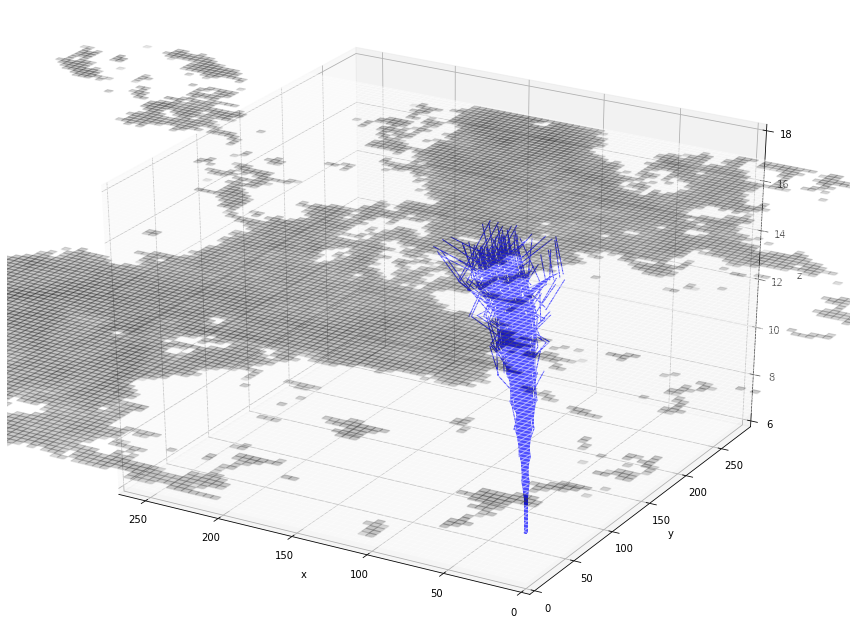

In [70]:
impng = read_png('/user/workdir/albouyg/Gouldbelt/Aquila_loc/aquila_500.png')
impng = np.flip(impng, axis=0)
x, y = ogrid[0:impng.shape[0], 0:impng.shape[1]]
figure(figsize=(12,9))
ax = gca(projection='3d')
z = np.zeros((impng.shape[0],impng.shape[1]))+smin
ax.plot_surface(x, y, z, rstride=5, cstride=5, facecolors=impng, shade=False, alpha=0.3)
#for src in range(256):
#for src in np.where((powlaw < -4.))[0]:
#for src in np.where((powlaw > -1.5) & (mass < 5.0))[0]:
#for src in np.where((powlaw >= -2.5) & (mass > 5.0))[0]:
#for src in np.where((plevel > 0.1e46))[0]:
#for src in np.where((plevel > np.exp(1.84*powlaw + 106.15)))[0]:
for src in np.where((plevel > 1e40))[0]:
    ax.plot(np.flip(allylcoordsM[src,:],axis=0),np.flip(allxlcoordsM[src,:],axis=0),arange(smin, smax+1),zdir='z', linewidth=1.0, color='blue')
    #ax.text(allylcoordsM[src,-4],allxlcoordsM[src,-4],smax+1,np.str(src),fontsize=22)
ax.set_xlim([0,im.shape[0]])
ax.set_ylim([0,im.shape[1]])
ax.invert_xaxis()
#ax.invert_zaxis()
ax.set_zlim([smin, smax])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#xticks([])
#yticks([])
tight_layout()

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Mean of empty slice
/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


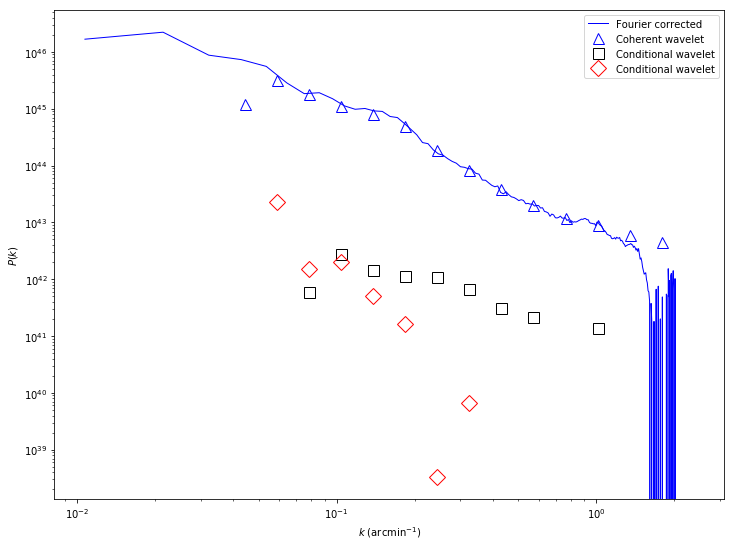

In [98]:
smin2, smax2 = (6,18)

#condition = np.where(mass > 0.)
condition = np.where((mass < 5.))
#condition = np.where((powlaw >= -1.5) & (mass > 10.0))
#condition = np.where((plevel > 2.5e+43))
#condition = np.where((powlaw > -1.5) & (mass > 1.0))
#condition = np.where((powlaw > -3.0) & (powlaw <= -2.0) & (mass < 5.0))
#condition = np.where((powlaw < -1.5) & (mass > 20.0))
#condition = np.where(plevel < np.exp(1.84*powlaw + 106.15))
cond_powC = np.zeros((condition[0].size,smax2 - smin2 + 1))
cond_powG = np.zeros((condition[0].size,smax2 - smin2 + 1))

ii = 0
#for src in range(256):
for src in condition[0]:
#src = 45
    xpr, ypr = np.int(xp[src]),np.int(yp[src])
    coords = np.array((xpr, ypr))
    if (coords[0] > 0) & (coords[1] > 0) & (coords[1] < wt.shape[2]) & (coords[0] < wt.shape[3]):
        locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt[M:2*M,:,:], reso, smin2, smax2, radlim=0.5, phaslim=0.25)
    Mlocpow = np.nanmean(locpow, axis=0)
    cond_powC[ii,:] = Mlocpow
    ii =+ 1
    
ii = 0
#for src in range(256):
for src in condition[0]:
#src = 45
    xpr, ypr = np.int(xp[src]),np.int(yp[src])
    coords = np.array((xpr, ypr))
    if (coords[0] > 0) & (coords[1] > 0) & (coords[1] < wt.shape[2]) & (coords[0] < wt.shape[3]):
        locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt[2*M:3*M,:,:], reso, smin2, smax2, radlim=0.5, phaslim=0.25)
    Mlocpow = np.nanmean(locpow, axis=0)
    cond_powG[ii,:] = Mlocpow
    ii =+ 1
    
Mcond_powC = np.nanmean(cond_powC, axis=0)
Mcond_powG = np.nanmean(cond_powG, axis=0)

plt.figure(figsize(12,9))
plt.plot(tab_k, (spec_k-noise)/spec_kbeamn, color='blue',label=r'Fourier corrected', lw=1.0)
plt.plot(wav_k[:-1], (S1a[1,:-1]-noise)/BS1an[:-1],'^', markersize = 11, markerfacecolor='none', markeredgecolor='blue', label='Coherent wavelet')
plt.plot(wav_k[smin2:smax2+1], (Mcond_powC-noise)/BS1an[smin2:smax2+1],'s', markersize = 11, markerfacecolor='none', markeredgecolor='black', label='Conditional wavelet')
plt.plot(wav_k[smin2:smax2+1], (Mcond_powG-noise)/BS1an[smin2:smax2+1],'D', markersize = 11, markerfacecolor='none', markeredgecolor='red', label='Conditional wavelet')
#plt.plot(wav_k, fit,'--',color='black', linewidth=1.5, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  
/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice


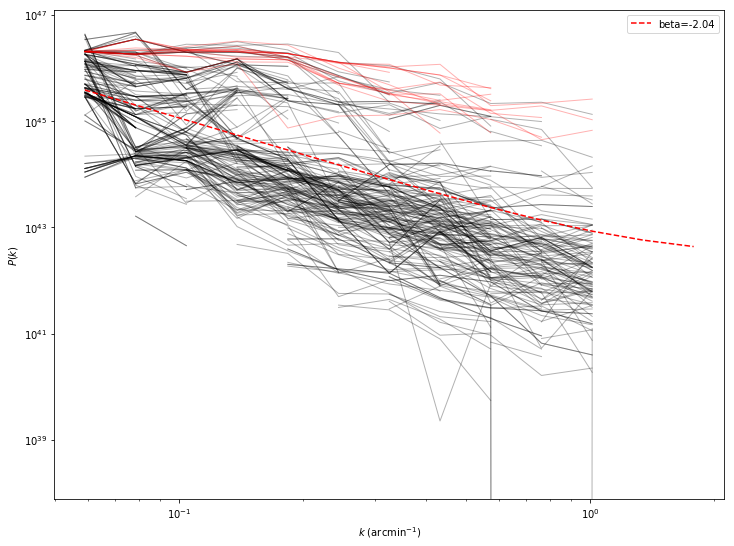

In [77]:
#mod1 = 1.e+42*wav_k**-4.0
#mod2 = 1.e+45*wav_k**-2.5

plt.figure(figsize(12,9))
condition = np.where(mass <= 10.)
for src in condition[0]:
    xpr, ypr = np.int(xp[src]),np.int(yp[src])
    coords = np.array((xpr, ypr))
    if (coords[0] > 0) & (coords[1] > 0) & (coords[1] < wt.shape[2]) & (coords[0] < wt.shape[3]):
        locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt, reso, smin, smax, radlim=0.5, phaslim=0.25)
    Mlocpow = np.nanmean(locpow, axis=0)
    plt.plot(wav_k[smin:smax+1], (Mlocpow-noise)/BS1an[smin:smax+1],lw=1.0, alpha=0.3, color='black')
    
condition = np.where(plevel > np.exp((1.92*powlaw + 105.94)))
condition = np.where(mass > 10.)
for src in condition[0]:
    xpr, ypr = np.int(xp[src]),np.int(yp[src])
    coords = np.array((xpr, ypr))
    if (coords[0] > 0) & (coords[1] > 0) & (coords[1] < wt.shape[2]) & (coords[0] < wt.shape[3]):
        locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt, reso, smin, smax, radlim=0.5, phaslim=0.25)
    Mlocpow = np.nanmean(locpow, axis=0)
    plt.plot(wav_k[smin:smax+1], (Mlocpow-noise)/BS1an[smin:smax+1],lw=1.0, alpha=0.3, color='red')

plt.plot(wav_k[smin:smax+1], fit_cohe[smin:smax+1],'--',color='red',lw=1.5, ls='--', label='beta=-2.04')
#plt.plot(wav_k[smin:smax+1], mod1[smin:smax+1],lw=1.5, ls='-.', color='black', label='beta=-4.0')
#plt.plot(wav_k[smin:smax+1], mod2[smin:smax+1],lw=1.5, ls='--', color='black', label='beta=-2.5')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P(k)$')
plt.legend()

#plt.savefig(figpath+'NGC2264_locpow_all.pdf',dpi=150,bbox_inches='tight')

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  
/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: Mean of empty slice


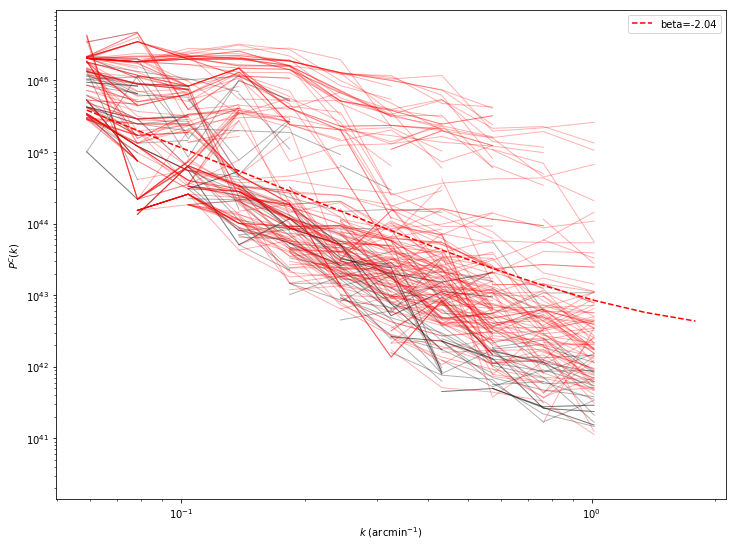

In [80]:
plt.figure(figsize(12,9))
condition = np.where(mass <= 0.5)
for src in condition[0]:
    xpr, ypr = np.int(xp[src]),np.int(yp[src])
    coords = np.array((xpr, ypr))
    if (coords[0] > 0) & (coords[1] > 0) & (coords[1] < wt.shape[2]) & (coords[0] < wt.shape[3]):
        locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt[M:2*M], reso, smin, smax, radlim=0.5, phaslim=0.25)
    Mlocpow = np.nanmean(locpow, axis=0)
    plt.plot(wav_k[smin:smax+1], (Mlocpow-noise)/BS1an[smin:smax+1], lw=1.0, alpha=0.3, color='black')
    
condition = np.where(plevel > np.exp((1.92*powlaw + 105.94)))
condition = np.where(mass > 0.5)
for src in condition[0]:
    xpr, ypr = np.int(xp[src]),np.int(yp[src])
    coords = np.array((xpr, ypr))
    if (coords[0] > 0) & (coords[1] > 0) & (coords[1] < wt.shape[2]) & (coords[0] < wt.shape[3]):
        locpow, xlcoords, ylcoords = locspec(coords, wav_k, wt[M:2*M], reso, smin, smax, radlim=0.5, phaslim=0.25)
    Mlocpow = np.nanmean(locpow, axis=0)
    plt.plot(wav_k[smin:smax+1], (Mlocpow-noise)/BS1an[smin:smax+1],lw=1.0, alpha=0.3, color='red')

plt.plot(wav_k[smin:smax+1], fit_cohe[smin:smax+1],'--',color='red',lw=1.5, ls='--', label='beta=-2.04')
#plt.plot(wav_k[smin:smax+1], fit_gauss[smin:smax+1],'--',color='blue',lw=1.5, ls='--', label='beta=-3.3')
#plt.plot(wav_k[smin:smax+1], mod1[smin:smax+1],lw=1.5, ls='-.', color='black', label='beta=-4.0')
#plt.plot(wav_k[smin:smax+1], mod2[smin:smax+1],lw=1.5, ls='--', color='black', label='beta=-2.5')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$k$ (arcmin$^{-1}$)')
plt.ylabel(r'$P^{C}(k)$')
plt.legend()

In [112]:
np.where((powlaw > -2.) & (mass < 5.))

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


(array([  0,   2,   4,   9,  11,  14,  22,  23,  28,  29,  35,  37,  38,
         40,  43,  46,  48,  50,  51,  52,  64,  67,  73,  74,  77,  82,
         83,  86,  87,  88,  89,  99, 108, 110, 113, 116, 130, 136, 137,
        143, 164, 165, 173, 179, 184, 190, 203, 206, 207, 209, 212, 218,
        222, 226, 234, 239, 240, 252, 253, 254]),)

/nix/store/95553ya337nh3azs93fxgibhwfrsl81z-python3-3.7.2-env/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


INFO: Auto-setting vmin to  1.587e+21 [aplpy.core]
INFO: Auto-setting vmax to  5.831e+22 [aplpy.core]


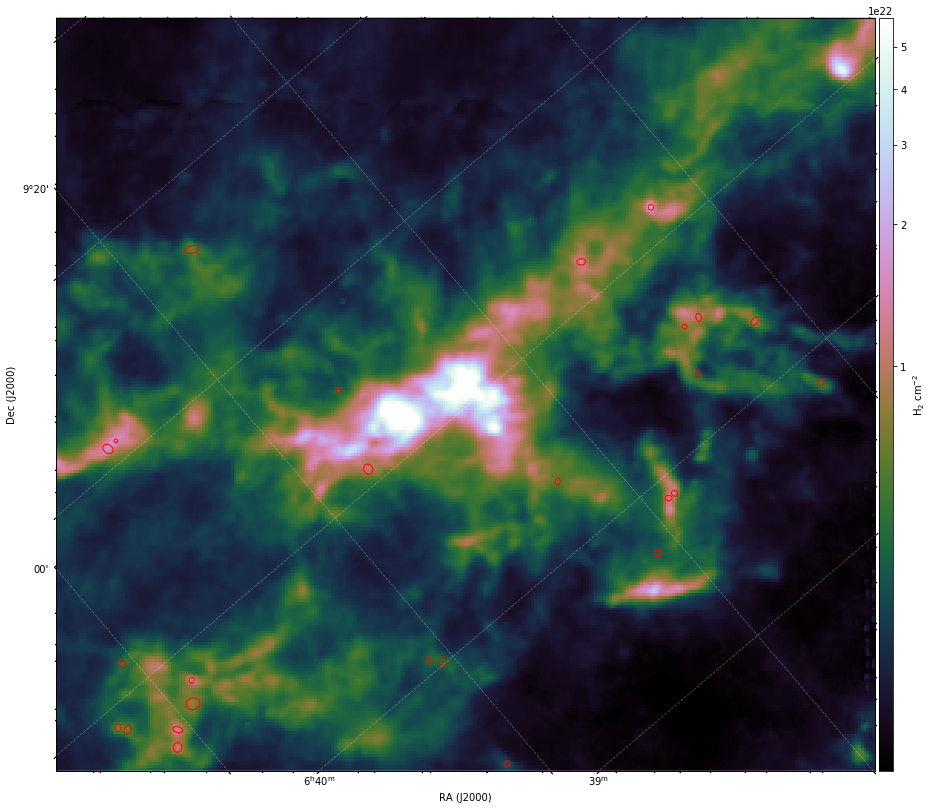

In [116]:
fig_all = plt.figure(1, figsize=(15,15))
condition = np.where((powlaw > -1.5) & (mass < 5.))
fig = aplpy.FITSFigure(figfile,figure=fig_all)
fig.show_colorscale(cmap='cubehelix',stretch='arcsinh')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')
#fig.set_title("NGC2264")
fig.add_grid()
fig.grid.set_color('white')
fig.grid.set_alpha(0.3)
fig.grid.set_linestyle('--')
fig.show_ellipses(ac[condition[0]], dec[condition[0]], width[condition[0]]/3600, height[condition[0]]/3600, angle=angle[condition[0]]-90., edgecolor='red', facecolor='none')
#for ii in range(256):
#    fig.add_label(ac[ii], dec[ii], ii, color='black',fontsize=18)
#ii = 32
#fig.add_label(ac[ii], dec[ii], ii, color='yellow',fontsize=18)
(xp, yp) = fig.world2pixel(ac, dec)

#plt.tight_layout()
#figpath = '/Users/robitaij/postdoc/NGC2264_letter/paper/figures/'
#plt.savefig(figpath+'NGC2264.pdf',dpi=150,bbox_inches='tight')